In [3]:
using LinearAlgebra, Distributions, Random, StatsFuns
using Formatting, ArgCheck
using Flux
using Flux: Tracker
using PyPlot

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/alexbird/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
using Revise
# Load in the specialized libraries for the MTDS and inference thereof.
using MTDS, SeqAdaptiveIS

const unsqueeze = MTDS.unsqueeze
make_untracked(m) = mapleaves(Tracker.data, m)   # remove AD tracking from model

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/MTDS/PZTu2.ji for MTDS [74fb3a10-692e-11ea-3656-8f980201e5bc]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/SeqAdaptiveIS/gHEdt.ji for SeqAdaptiveIS [b4864a18-6930-11ea-2360-8311ae906e1d]
└ @ Base loading.jl:1184


unsqueeze (generic function with 1 method)

# Single Damped Harmonic Oscillator

Our first experiment uses 1-dimensional time series generated by a damped harmonic oscillator (DHO). The data are generated below with the log decay rate $\log \rho$ and frequency $\omega$ of each sequence drawn as:

\begin{align}
    \log \rho \,&\sim\, \textrm{Uniform}(4, 80) \\
    \omega \,&\sim\, \textrm{Uniform}\left(6.75\frac{2\pi}{360},\, 36\frac{2\pi}{360}\right)
\end{align}

Each sequence begins from the same initial state $\mathbf{x}_0 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$.

In [11]:
# Generate data

trans_matrix_2d(θ, ρ) = ρ .* [cos(θ) sin(θ); -sin(θ) cos(θ)];

function evaluate_state_deterministic(A, x0, timesteps)
    X = Matrix{Float64}(undef, size(A, 1), timesteps+1)
    X[:,1] = x0
    for tt = 1:timesteps; X[:,tt+1] = A * X[:,tt]; end
    return X
end;

Random.seed!(80)
const Ctrue = [1. 0.]
p_ρ_log = Uniform(4, 80)
p_ω = Uniform((6.75/360) * 2π, (36/360) * 2π)
x0 = [0 1]

N = 40
TS_LEN = 80
seq_deterministic, seq_noise = [], []

rsob = MTDS.util.uniform_rand_sobol(N, [p_ω.a, p_ω.b], [p_ρ_log.a, p_ρ_log.b])
for nn = 1:N
    A = trans_matrix_2d(rsob[nn,1], exp(log(0.5)/rsob[nn,2]))
    Xcur = evaluate_state_deterministic(A, x0, TS_LEN-1)'*Ctrue'
    push!(seq_deterministic, Xcur[:])
    push!(seq_noise,  Xcur[:] .+ randn(TS_LEN)*0.05)
end
seq_noise = f32(reduce(hcat, seq_noise));

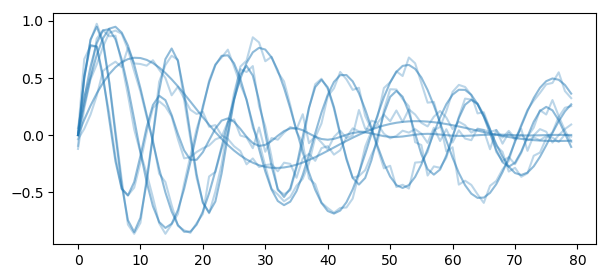

In [52]:
# Plot some examples
[plot(seq_deterministic[i], color=ColorMap("tab10")(0), alpha=0.5) for i in 1:5]; 
[plot(seq_noise[:,i], color=ColorMap("tab10")(0), alpha=0.3) for i in 1:5]; 
gcf().set_size_inches(7,3)

## Create simple MT-LDS

The function `create_mtlds(d_x, d_in, d_y, d_enc_state, d_mt; encoder=:RNN)` creates a deterministic state MT-LDS defined as:

\begin{align}
  \mathbf{z} \,&\sim\, \mathcal{N}(0, I) \\
  \mathbf{x}_t \,&=\, A_z\,\mathbf{x}_{t-1} + B_z\, \mathbf{u}_{t}  \\
  y_t \,&=\, C_z\,\mathbf{x}_{t} + d_z + \sigma\epsilon_t
\end{align}

where $\epsilon_t \sim \mathcal{N}(0, I)$. The subscripts show dependence on $\mathbf{z}$. Here, $\{A, B, C, d\} \,=\, \boldsymbol{\theta} \,=\,\mathbf{h}_{\boldsymbol{\phi}}(\mathbf{z})$, and the learnable parameters are $\{\boldsymbol{\phi}, \sigma\}$. The parameterizations of $A$ and $B$ are not straight-forward, and follow the constructions discussed in [https://arxiv.org/abs/1910.05026](https://arxiv.org/abs/1910.05026) (see Section A.1.2, cf. 2.1.1), using a diagonal-orthogonal construction, and the product of $\tanh$ and logistic sigmoid matrices respectively.

We choose a simple example with a 2-dimensional state and 2-dimensional $\mathbf{z}$, and train on a collection of 1-dimensional time series (damped harmonic oscillator data). Here we expect the model to learn a latent space $\mathbb{R}^2$ which represents axes of oscillation frequency and decay. This allows us to ensure the procedure works, and produces a model which can be easily investigated.

In [35]:
# Doc string help
?MTLDS_variational

search: MTLDS_variational



```
MTLDS_variational(mt_enc, mt_post, hphi, emission, d, flag_mt_emission,
flag_mt_x0)
```

A deterministic MT-LDS model (subtype of `MTDSModel`) following the equations:

$x_t = A_z x_{t-1} + B_z u_{t}$

$y_t = C_z x_y + d_z + s .* ϵ_t$

for $ϵ_t \sim 𝑵(0, I)$ and $x_0 = 0$. Note the following restrictions vs a full LDS:

1. Latent system is deterministic.
2. The inputs cannot affect the emission process (i.e. no $D_z u_t$ term).
3. The latent state $x_0$ is constant and equal to zero.
4. The emission covariance is diagonal.

The limitations exist because this was all I needed for my experiments, but it is not difficult to extend the model to relax each of these, especially (2-4).

## Struct description

The model is variational in $z$, and contains an encoder (`mt_enc`) which is an RNN which encodes the sequences `Y` and `U` (which should be of size $d × T × n_b$, where $d$ is the size of each vector, $T$ is the sequence length, and $n_b$ is the batch size) into a single vector. The `mt_post` network is a network which returns a tuple of (mean, (diagonal) sqrt variance) defining a variational Gaussian posterior. The method `encode` will return two tuples, the first of which is a sample from this posterior (using reparameterization), elements 2 and 3 are the variational posterior mean and stdev components. (The second tuple is empty – this is reserved for $x_0$ if it has a separate encoder.) Note that these variational networks need not be used, e.g. if one is using an alternative MCO approach.

The function `hphi` is a network $h_ϕ: \text{dom}(z) → \text{dom}(θ)$ which takes a $k × n_b$ matrix $z$ and returns the LDS parameter vector θ. The `emission` is either a pre-specified network which is optimized without any MT modulation, or an Int which specifies the emission dimension, for which a MT affine emission is constructed ($C_z + d_z$). Finally $flag_mt_emission$ is a boolean which is true in the latter case (MT affine emission) and false otherwise, and `flag_mt_x0` is a placeholder for whether the $x_0$ is modulated via $z$.

## Methods

As per all `MTDSModel` objects, the following interface is available:

  * `encode(m::MTLDS_variational, Y::AbstractArray{T}, U::AbstractArray{T})`, which encodes the sequences `Y` and `U` into a sample and variational posterior parameters of $z$.
  * `forward(m::MTLDS_variational, z::AbstractVecOrMat{T}, U::AbstractArray{T})`, the forward model, which constructs the LDS for the latent variable `z` and calculates the output mean.
  * `reconstruct(m::MTDSModel, Y, U)` which performs both `encode` and `forward` operations, effectively reconstructing `Y` through the bottleneck of the inference of $z$.

### Constructor

See `create_mtlds` for a more helpful constructor.


In [10]:
# For more information about arguments, see ?create_mtlds
# Note that this creates a `MTLDS_variational` type, but the variational posterior
# need not be used (and first-off, we will not -- see below).

m_dho = create_mtlds(2, 1, 1, 32, 2; encoder=:RNN)

MTLDS_variational(state=2, in=1, out=1, d_mt=2, non-MT hidden state)

## Learning via Monte Carlo gradients

** \* The uninterested reader/user may skip this section. \* **


Our objective function is the marginal likelihood. The model can be learned via a standard variational lower bound (ELBO, and the codebase has support for this), but we can do better when no inputs are available, i.e. $u_t = \varnothing$ for all $t$ as in this case. Consider a collection of time series $\{\mathbf{y}_{1:T_1}^{(1)}, \mathbf{y}_{1:T_2}^{(2)}, \ldots, \mathbf{y}_{1:T_N}^{(N)}\}$, the objective is:

$$
L(\boldsymbol{\phi}, \sigma) \,=\, \sum_{i=1}^N \log p(Y^{(i)}),
$$

where $Y^{(i)} := \mathbf{y}_{1:T_i}^{(i)}$. Taking the gradient,

\begin{align}
    \nabla L(\boldsymbol{\phi}, \sigma) \,&=\, \sum_{i=1}^N \nabla \log p(Y^{(i)}) \,=\, \sum_{i=1}^N \frac{1}{p(Y^{(i)})}\nabla p(Y^{(i)})\\
    &=\, \sum_{i=1}^N \frac{1}{p(Y^{(i)})}\nabla \int p(Y^{(i)}, \mathbf{z}) \,d \mathbf{z} \\
    &=\, \sum_{i=1}^N \frac{1}{p(Y^{(i)})} \int\, \nabla p(Y^{(i)}, \mathbf{z}) \,d \mathbf{z} \\
    &=\, \sum_{i=1}^N \frac{1}{p(Y^{(i)})} \int\, p(Y^{(i)}, \mathbf{z})\nabla \log p(Y^{(i)}, \mathbf{z}) \,d \mathbf{z} \\
    &=\,\sum_{i=1}^N  \int\, p(\mathbf{z}\,\mid\,Y^{(i)})\,\nabla \log p(Y^{(i)}, \mathbf{z}) \,d \mathbf{z} \label{fisheridentity} \tag{1}\\
    &=\,\sum_{i=1}^N  \int\, \frac{p(\mathbf{z}\,\mid\,Y^{(i)})}{p(\mathbf{z})} \left[\nabla \log p(Y^{(i)}, \mathbf{z})\right] \,p(\mathbf{z})\,d \mathbf{z}  \label{mcograd1} \tag{2}
\end{align}

Observe that eq. (\ref{mcograd1}) is written in an importance sampling form, where each of the $N$ integrals has the same proposal. Furthermore, the distribution $\sum_{i=1}^N  p(\mathbf{z}\,\mid\,Y^{(i)})$ is the aggregate posterior (up to a normalizing constant $1/N$), which, as noted by various recent authors (e.g. Makhzani et al., 2015; Hoffman and Johnson, 2016), should be similar to the prior at convergence. We exploit this fact by taking **one set** of samples from the proposal $\{\mathbf{z}_m\}_{m=1}^M$, where $\mathbf{z}_m \,\sim\, p(\mathbf{z})$, to be shared across all $N$ integrals; i.e. for each each sample $\mathbf{z}_m$, run the model forward once, and calculate the likelihood of each of the $N$ sequences. The resulting importance sampling estimate should be relatively low variance (at convergence) due to the similarity of target and proposal distributions. Alternatively one can argue that we have amortized the cost of sampling by a factor of $N$, allowing us to take a greater number of samples.

Due to the fact that importance sampling is biased for finite $M$, we therefore are not (quite) optimizing the objective $L(\boldsymbol{\phi}, \sigma)$. The derivation we have just followed is based on approximating eq. (\ref{fisheridentity}) (also known as the Fisher identity, see Douc et al., 2014, sec. D2), but this gradient may instead be derived as the exact gradient of a Monte Carlo objective (see Mnih and Rezende, 2016):

\begin{align}
L_{\text{MCO}}(\boldsymbol{\phi}, \sigma) \,&:=\, \sum_{i=1}^N \mathbb{E}_{p(\mathbf{z}_{1:M})}\left[\log \frac{1}{M} \sum_{m=1}^M p(Y^{(i)} \,|\, \mathbf{z}_m) \right] \\
&\le\, \sum_{i=1}^N \log \mathbb{E}_{p(\mathbf{z}_{1:M})}\left[\frac{1}{M} \sum_{m=1}^M p(Y^{(i)} \,|\, \mathbf{z}_m) \right] = \sum_{i=1}^N \log p(Y^{(i)})
\end{align}

which is a lower bound of the marginal log likelihood. The equivalence of the gradient here is left as an exercise for the reader. Both interpretations have the desirable property of optimizing the true marginal likelihood as $M \rightarrow \infty$.

In [12]:
# Train
tT = 80              # Total num timesteps (shouldn't use T ∵ julia reserves for type)
nepochs = 250
opt_pars_dho = MTDS.model.training_params_mco(samples=400)
_dho_u = reshape(MTDS.util.e1(tT), 1, tT, 1)

history = MTDS.model.train_mco!(m_dho, unsqueeze(seq_noise,1), _dho_u, nepochs; opt_pars=opt_pars_dho, tT=tT)

Epoch 0001 Loss: 120.25, logp: -3.96 (5.2s)
Epoch 0002 Loss: 81.86, logp: 33.60 (0.7s)
Epoch 0003 Loss: 25.73, logp: 76.99 (0.7s)
Epoch 0004 Loss: -92.56, logp: 153.35 (0.6s)
Epoch 0005 Loss: -184.49, logp: 233.96 (0.7s)
Epoch 0006 Loss: -243.60, logp: 289.77 (0.7s)
Epoch 0007 Loss: -299.75, logp: 342.38 (0.7s)
Epoch 0008 Loss: -346.81, logp: 388.97 (0.8s)
Epoch 0009 Loss: -396.49, logp: 433.84 (0.7s)
Epoch 0010 Loss: -440.22, logp: 474.24 (0.7s)
Epoch 0011 Loss: -482.57, logp: 510.26 (0.8s)
Epoch 0012 Loss: -525.70, logp: 552.10 (0.7s)
Epoch 0013 Loss: -563.90, logp: 586.11 (0.7s)
Epoch 0014 Loss: -603.21, logp: 625.21 (0.6s)
Epoch 0015 Loss: -648.02, logp: 670.96 (0.7s)
Epoch 0016 Loss: -689.56, logp: 709.70 (0.7s)
Epoch 0017 Loss: -730.78, logp: 751.19 (0.6s)
Epoch 0018 Loss: -766.05, logp: 785.16 (0.6s)
Epoch 0019 Loss: -796.56, logp: 813.93 (0.7s)
Epoch 0020 Loss: -832.48, logp: 847.36 (0.7s)
Epoch 0021 Loss: -865.46, logp: 878.94 (0.7s)
Epoch 0022 Loss: -892.11, logp: 903.96 (0.7

Epoch 0174 Loss: -1441.50, logp: 1442.11 (0.7s)
Epoch 0175 Loss: -1453.70, logp: 1453.89 (0.7s)
Epoch 0176 Loss: -1459.69, logp: 1459.85 (0.7s)
Epoch 0177 Loss: -1473.06, logp: 1472.98 (0.8s)
Epoch 0178 Loss: -1450.23, logp: 1450.50 (0.7s)
Epoch 0179 Loss: -1458.55, logp: 1458.58 (0.7s)
Epoch 0180 Loss: -1440.80, logp: 1440.10 (0.7s)
Epoch 0181 Loss: -1433.61, logp: 1433.80 (0.7s)
Epoch 0182 Loss: -1447.91, logp: 1448.22 (0.7s)
Epoch 0183 Loss: -1444.22, logp: 1443.81 (0.8s)
Epoch 0184 Loss: -1456.66, logp: 1457.14 (0.7s)
Epoch 0185 Loss: -1466.52, logp: 1467.15 (0.8s)
Epoch 0186 Loss: -1465.16, logp: 1465.08 (0.8s)
Epoch 0187 Loss: -1464.87, logp: 1464.75 (0.8s)
Epoch 0188 Loss: -1460.27, logp: 1460.19 (0.7s)
Epoch 0189 Loss: -1463.16, logp: 1462.94 (0.7s)
Epoch 0190 Loss: -1460.42, logp: 1460.44 (0.7s)
Epoch 0191 Loss: -1449.88, logp: 1450.04 (0.8s)
Epoch 0192 Loss: -1482.06, logp: 1482.32 (0.7s)
Epoch 0193 Loss: -1469.06, logp: 1469.28 (0.8s)
Epoch 0194 Loss: -1442.21, logp: 1441.88

250-element Array{Float64,1}:
   -3.9649207491628187
   33.59983848145089  
   76.99462665131172  
  153.3501249652155   
  233.9574156146296   
  289.766247401739    
  342.3782224993952   
  388.9675993304499   
  433.8416761737116   
  474.23555739929753  
  510.2577162127741   
  552.1017134051568   
  586.1118971209773   
    ⋮                 
 1472.5679640155086   
 1464.440797267462    
 1470.3824903826958   
 1462.4412916522274   
 1460.0042311053521   
 1466.7595838885554   
 1450.2231214862118   
 1459.5743543963677   
 1462.0487989764456   
 1465.1232862811335   
 1476.810426173712    
 1472.8509779315243   

## Visualize latent encoding
There is no encoder or variational posterior due to training via MCO. Instead we **draw latent samples via Monte Carlo**.

(**Warning**: While the `MTDS.encode` method will produce *something*, it has not been trained.)

In [37]:
# remove AD tracking from model (note that `m_dho`/`m_dho_u` still share same memory space)
m_dho_u = make_untracked(m_dho)

# sample from p(z) = N(0,I), returning samples (Z) and importance weights (W)
Z, W, logp = MTDS.model.aggregate_importance_smp(m_dho_u, unsqueeze(seq_noise,1), _dho_u; M=500)

# resample 4 samples for each sequence i ∈ 1:N
smps = [MTDS.util.categorical_sampler(W[:, i], 4) for i ∈ 1:N];

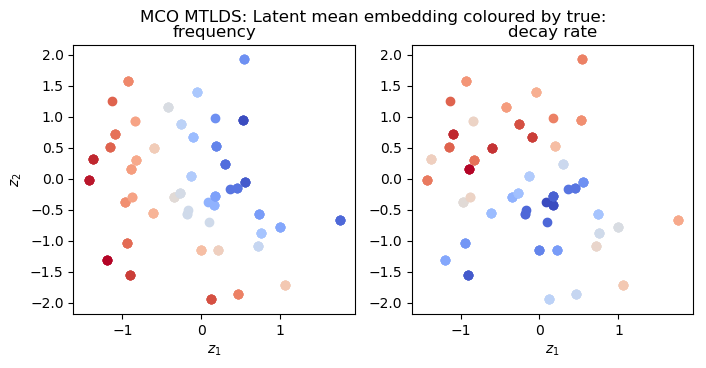

In [40]:
fig, axs = subplots(1,2,figsize=(8,3.5))
for i in 1:N
    for c_ix in 1:2
        c = -(rsob[i,c_ix] - minimum(rsob[:,c_ix])) / (-(extrema(rsob[:,c_ix])...))
        axs[c_ix].scatter(Z[1,smps[i]], Z[2,smps[i]], color=ColorMap("coolwarm")(c))
    end
end
gcf().suptitle("MCO MTLDS: Latent mean embedding coloured by true:")
[axs[i].set_title(["frequency", "decay rate"][i]) for i in 1:2];
[(axs[i].set_xlabel(L"z_1"); i == 1 ? axs[i].set_ylabel(L"z_2") : nothing) for i in 1:2];

The latent space demonstrates a 2D embedding of the inter-sequence differences with $z_1$ approximately corresponding to frequency and $z_2$ to decay rate. The embedding of these features is not quite linear, as may be expected from use of a neural network for $h_{\boldsymbol{\phi}}$.

### Random samples from model
Perform model checking by drawing samples from the model.

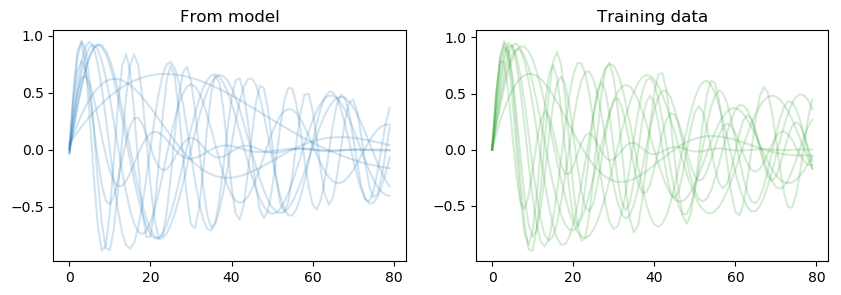

In [71]:
# covariance of aggregate posterior can be a little smaller
C = cov(Z[:,unique(reduce(vcat, smps))], dims=2)

fig, axs = subplots(1,2,figsize=(10,3))
let _u = zeros(Float32, 1, 80, 20); _u[:,1,:] .= 1; 
    _yhat = m_dho_u(cholesky(C).L * f32(MTDS.util.sobol_gaussian(20,2)'), _u);
    [axs[1].plot(_yhat[1,:,i], color=ColorMap("tab10")(0), alpha=0.2) for i in 1:10]; 
end;
[axs[2].plot(seq_deterministic[i], color=ColorMap("tab10")(2), alpha=0.2) for i in 1:10]; 
axs[1].set_title("From model"); axs[2].set_title("Training data");

The resulting sequences look like damped harmonic oscillation with approximately the right scale length and decay factors. The model seems to permit slightly lower frequencies than the training data, which may be seen as extrapolation.

## Compare to variational objective

Instead of the MCO approach, we can use a variational lower bound (ELBO) using Gaussian posteriors. We can train via this objective by little more than using the `MTDS.model.training_params_elbo` function instead of `MTDS.model.training_params_mco`.

In [86]:
m_dho_elbo = create_mtlds(2, 1, 1, 32, 2; encoder=:RNN)

MTLDS_variational(state=2, in=1, out=1, d_mt=2, non-MT hidden state)

Learning the model via variational methods can suffer from a form of latent collapse. The argument `hard_em_epochs` sets the posterior to a delta function for the specified number of epochs with no KL penalty. We also perform KL annealing here, which uses a linear schedule, increasing by 0.005 per batch until maxing out at 1 (= `kl_mult`).

I was personally surprised that I needed to do this given how simple the model is, and since there are no inputs after $t=1$.

In [87]:
tT = 80 
nepochs = 250
opt_pars_dho = MTDS.model.training_params_elbo(kl_mult=1, kl_anneal=5f-3, hard_em_epochs=50)
_dho_u = reshape(MTDS.util.e1(tT), 1, tT, 1)

history = MTDS.model.train_elbo!(m_dho_elbo, unsqueeze(seq_noise,1), _dho_u, nepochs; opt_pars=opt_pars_dho, tT=tT)

Epoch 0001 Loss: 120.31, kl: 0.00, p_logstd: -47.87 (0.7s)
Epoch 0002 Loss: 81.10, kl: 0.00, p_logstd: -94.75 (0.7s)
Epoch 0003 Loss: 49.53, kl: 0.00, p_logstd: -140.00 (0.7s)
Epoch 0004 Loss: 13.88, kl: 0.00, p_logstd: -183.75 (0.7s)
Epoch 0005 Loss: -9.60, kl: 0.00, p_logstd: -225.54 (0.8s)
Epoch 0006 Loss: -36.37, kl: 0.00, p_logstd: -264.85 (0.7s)
Epoch 0007 Loss: -58.06, kl: 0.00, p_logstd: -301.15 (0.7s)
Epoch 0008 Loss: -83.04, kl: 0.00, p_logstd: -336.18 (0.7s)
Epoch 0009 Loss: -78.90, kl: 0.00, p_logstd: -366.61 (0.7s)
Epoch 0010 Loss: -107.32, kl: 0.00, p_logstd: -394.43 (0.7s)
Epoch 0011 Loss: -134.03, kl: 0.00, p_logstd: -422.93 (0.8s)
Epoch 0012 Loss: -103.13, kl: 0.00, p_logstd: -444.21 (0.8s)
Epoch 0013 Loss: -119.45, kl: 0.00, p_logstd: -460.05 (0.8s)
Epoch 0014 Loss: -126.10, kl: 0.00, p_logstd: -475.28 (0.7s)
Epoch 0015 Loss: -143.58, kl: 0.00, p_logstd: -489.68 (0.7s)
Epoch 0016 Loss: -140.97, kl: 0.00, p_logstd: -505.01 (0.7s)
Epoch 0017 Loss: -95.77, kl: 0.00, p_lo

Epoch 0132 Loss: -1183.38, kl: 193.27, p_logstd: -1671.23 (0.7s)
Epoch 0133 Loss: -1213.17, kl: 192.65, p_logstd: -1685.04 (0.7s)
Epoch 0134 Loss: -1199.53, kl: 189.46, p_logstd: -1697.95 (0.7s)
Epoch 0135 Loss: -1228.97, kl: 191.01, p_logstd: -1710.12 (0.7s)
Epoch 0136 Loss: -1234.09, kl: 189.51, p_logstd: -1722.79 (0.7s)
Epoch 0137 Loss: -1212.79, kl: 191.16, p_logstd: -1733.11 (0.7s)
Epoch 0138 Loss: -1228.47, kl: 191.25, p_logstd: -1741.32 (0.8s)
Epoch 0139 Loss: -1189.97, kl: 191.71, p_logstd: -1747.64 (0.7s)
Epoch 0140 Loss: -1057.77, kl: 193.34, p_logstd: -1743.48 (0.7s)
Epoch 0141 Loss: -1167.56, kl: 192.06, p_logstd: -1740.58 (0.7s)
Epoch 0142 Loss: -1169.10, kl: 192.37, p_logstd: -1742.50 (0.7s)
Epoch 0143 Loss: -1214.99, kl: 191.26, p_logstd: -1747.00 (0.7s)
Epoch 0144 Loss: -1236.50, kl: 191.27, p_logstd: -1754.62 (0.7s)
Epoch 0145 Loss: -1252.82, kl: 191.36, p_logstd: -1763.41 (0.7s)
Epoch 0146 Loss: -1258.19, kl: 193.72, p_logstd: -1772.68 (0.7s)
Epoch 0147 Loss: -1268.55

250-element Array{Float64,1}:
   120.30728149414062 
    81.09727478027344 
    49.534507751464844
    13.87702751159668 
    -9.59837532043457 
   -36.36991882324219 
   -58.06309509277344 
   -83.04315948486328 
   -78.89627838134766 
  -107.32384490966797 
  -134.02528381347656 
  -103.12682342529297 
  -119.4500961303711  
     ⋮                
 -1371.4239501953125  
 -1378.0732421875     
 -1369.130126953125   
 -1378.1806640625     
 -1378.796875         
 -1378.09375          
 -1390.4200439453125  
 -1379.2694091796875  
 -1384.7071533203125  
 -1372.2882080078125  
 -1384.9691162109375  
 -1388.2774658203125  

## Visualize latent encoding
We can now use the `MTDS.encode` function since we have trained a variational posterior. The sequence is encoded via a recurrent neural network (RNN) into a diagonal Gaussian.

In [102]:
# Remove AD tracking
m_dho_elbo_u = make_untracked(m_dho_elbo);

# Calculate aggregate posterior
aggpost_μ = MTDS.encode(m_dho_elbo_u, unsqueeze(seq_noise,1), repeat(_dho_u, outer=(1,1,N)) )[1][2]
aggpost_σ = MTDS.encode(m_dho_elbo_u, unsqueeze(seq_noise,1), repeat(_dho_u, outer=(1,1,N)) )[1][3]
p_z_dho = MvNormal(mean(aggpost_μ; dims=2)[:], cov(aggpost_μ; dims=2) + Diagonal(mean(aggpost_σ; dims=2)[:]));

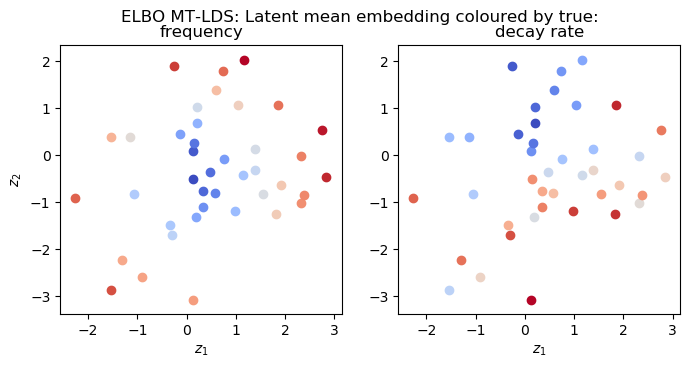

In [103]:
fig, axs = subplots(1,2,figsize=(8,3.5))
for i in 1:N
    for c_ix in 1:2
        c = -(rsob[i,c_ix] - minimum(rsob[:,c_ix])) / (-(extrema(rsob[:,c_ix])...))
        axs[c_ix].scatter(aggpost_μ[1,i], aggpost_μ[2,i], color=ColorMap("coolwarm")(c))
    end
end
gcf().suptitle("ELBO MT-LDS: Latent mean embedding coloured by true:")
[axs[i].set_title(["frequency", "decay rate"][i]) for i in 1:2];
[(axs[i].set_xlabel(L"z_1"); i == 1 ? axs[i].set_ylabel(L"z_2") : nothing) for i in 1:2];

The model has learned a different 2D embedding of the inter-sequence differences; here frequency appears to be encoded in an approximately radial fashion, and decay rate is approximately encoded by $z_2$, although there are some discrepancies (/nonlinearities).

The below cell investigates how well the model can reconstruct a sequence from its latent encoding:

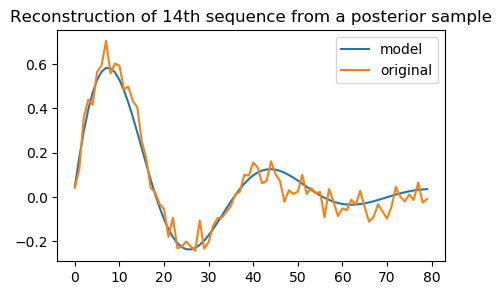

In [106]:
_i = 14
plot(MTDS.reconstruct(m_dho_elbo_u, unsqueeze(seq_noise[:,_i:_i],1), _dho_u)[:])
plot(seq_noise[:,_i]); gcf().set_size_inches(5,3)
title("Reconstruction of $(_i)th sequence from a posterior sample"); legend(["model", "original"]);

### Random samples from model
Perform model checking by drawing samples from the model.

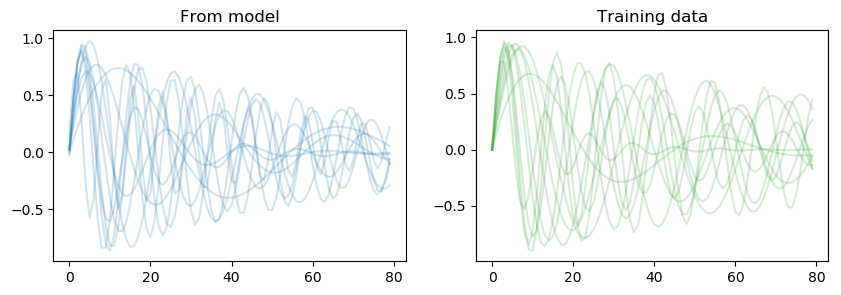

In [109]:
fig, axs = subplots(1,2,figsize=(10,3))
let _u = zeros(Float32, 1, 80, 20); _u[:,1,:] .= 1; 
    _yhat = m_dho_elbo_u(cholesky(p_z_dho.Σ).L * f32(MTDS.util.sobol_gaussian(20,2)'), _u);
    [axs[1].plot(_yhat[1,:,i], color=ColorMap("tab10")(0), alpha=0.2) for i in 1:10]; 
end;
[axs[2].plot(seq_deterministic[i], color=ColorMap("tab10")(2), alpha=0.2) for i in 1:10]; 
axs[1].set_title("From model"); axs[2].set_title("Training data");

The resulting sequences appear to capture the sequence family very well.

------------------
# Sum of Damped Harmonic Oscillators

In [26]:
const Ctrue = [1. 0. 1. 0.]
p_ρ_log, p_θ = Uniform(4, 80), Uniform((6.75/360) * 2π, (18/360) * 2π)
p_ρ2_log, p_θ2 = Uniform(8, 60), Uniform((22.5/360) * 2π, (36/360) * 2π)
x0 = [0 1 0 -0.5]

seq_deterministic2x, seq_noise2x = [], []

rsob2x = MTDS.util.uniform_rand_sobol(N, [p_θ.a, p_θ.b], [p_ρ_log.a, p_ρ_log.b], 
    [p_θ2.a, p_θ2.b], [p_ρ2_log.a, p_ρ2_log.b])
for nn = 1:N
    A1 = trans_matrix_2d(rsob2x[nn,1], exp(log(0.5)/rsob2x[nn,2]))
    A2 = trans_matrix_2d(rsob2x[nn,3], exp(log(0.5)/rsob2x[nn,4]))
    _A = cat(A1, A2, dims=[1,2])  # block diag
    Xcur = evaluate_state_deterministic(_A, x0, TS_LEN-1)'*Ctrue'
    push!(seq_deterministic2x, Xcur[:])
    push!(seq_noise2x,  Xcur[:] .+ randn(TS_LEN)*0.05)
end
seq_noise2x = f32(reduce(hcat, seq_noise2x));

In [27]:
m_dho2x = create_mtlds(4, 1, 1, 32, 4; encoder=:RNN)

MTLDS_variational(state=4, in=1, out=1, d_mt=4, non-MT hidden state)

In [28]:
# Train
tT = 80              # Total num timesteps (can't use T ∵ julia reserves for type)
nepochs = 250
opt_pars_dho = MTDS.model.training_params_mco(samples=800)
_dho_u = reshape(MTDS.util.e1(tT), 1, tT, 1)

history = MTDS.model.train_mco!(m_dho2x, unsqueeze(seq_noise2x,1), _dho_u, nepochs; opt_pars=opt_pars_dho, tT=tT)

Epoch 0001 Loss: 148.04, logp: -26.63 (2.0s)
Epoch 0002 Loss: 120.12, logp: 8.06 (1.3s)
Epoch 0003 Loss: 50.20, logp: 66.77 (1.3s)
Epoch 0004 Loss: -72.68, logp: 155.85 (1.3s)
Epoch 0005 Loss: -147.80, logp: 222.14 (1.3s)
Epoch 0006 Loss: -201.05, logp: 272.87 (1.3s)
Epoch 0007 Loss: -246.52, logp: 316.66 (1.3s)
Epoch 0008 Loss: -289.71, logp: 358.05 (1.3s)
Epoch 0009 Loss: -329.63, logp: 398.52 (1.3s)
Epoch 0010 Loss: -368.57, logp: 434.10 (1.4s)
Epoch 0011 Loss: -405.15, logp: 467.42 (1.3s)
Epoch 0012 Loss: -437.97, logp: 501.47 (1.3s)
Epoch 0013 Loss: -475.26, logp: 531.06 (1.3s)
Epoch 0014 Loss: -510.35, logp: 561.06 (1.3s)
Epoch 0015 Loss: -552.67, logp: 595.91 (1.3s)
Epoch 0016 Loss: -609.08, logp: 636.92 (1.3s)
Epoch 0017 Loss: -655.98, logp: 676.40 (1.3s)
Epoch 0018 Loss: -688.53, logp: 705.21 (1.4s)
Epoch 0019 Loss: -720.41, logp: 735.34 (1.3s)
Epoch 0020 Loss: -745.66, logp: 760.75 (1.5s)
Epoch 0021 Loss: -795.90, logp: 809.34 (1.4s)
Epoch 0022 Loss: -827.54, logp: 838.53 (1.

Epoch 0174 Loss: -1229.76, logp: 1230.23 (1.4s)
Epoch 0175 Loss: -1229.69, logp: 1229.64 (1.3s)
Epoch 0176 Loss: -1216.36, logp: 1216.41 (1.2s)
Epoch 0177 Loss: -1227.54, logp: 1227.77 (1.5s)
Epoch 0178 Loss: -1214.38, logp: 1214.72 (1.3s)
Epoch 0179 Loss: -1230.71, logp: 1231.37 (1.3s)
Epoch 0180 Loss: -1226.46, logp: 1226.93 (1.3s)
Epoch 0181 Loss: -1222.17, logp: 1222.38 (1.2s)
Epoch 0182 Loss: -1223.55, logp: 1223.80 (1.3s)
Epoch 0183 Loss: -1217.00, logp: 1217.37 (1.3s)
Epoch 0184 Loss: -1234.54, logp: 1235.33 (1.2s)
Epoch 0185 Loss: -1245.54, logp: 1246.46 (1.3s)
Epoch 0186 Loss: -1225.66, logp: 1226.86 (1.3s)
Epoch 0187 Loss: -1244.35, logp: 1245.26 (1.3s)
Epoch 0188 Loss: -1242.02, logp: 1242.92 (1.3s)
Epoch 0189 Loss: -1240.77, logp: 1241.11 (1.2s)
Epoch 0190 Loss: -1248.80, logp: 1248.55 (1.3s)
Epoch 0191 Loss: -1238.24, logp: 1238.64 (1.3s)
Epoch 0192 Loss: -1230.57, logp: 1231.31 (1.2s)
Epoch 0193 Loss: -1236.35, logp: 1236.74 (1.3s)
Epoch 0194 Loss: -1241.75, logp: 1242.11

250-element Array{Float64,1}:
  -26.628947878814273
    8.05742987301296 
   66.76782807018704 
  155.84867542889066 
  222.14170597698634 
  272.8659918656582  
  316.6618368973964  
  358.05343693401755 
  398.51609867718156 
  434.0985342850918  
  467.418776594662   
  501.47123325970125 
  531.0581244340176  
    ⋮                
 1261.4246619096039  
 1248.7826392045256  
 1265.3069128861662  
 1230.009555708432   
 1230.8693091264006  
 1245.4219641556977  
 1242.8836890092132  
 1251.7376440873384  
 1246.0673498978852  
 1245.592710005307   
 1232.5799841752287  
 1258.089548384213   

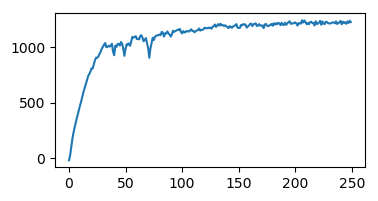

In [65]:
plot(history); gcf().set_size_inches(4,2)

### Random samples from model
Perform model checking by drawing samples from the model. It's hard to gain much from visualizing the 4-D latent space without extra work.

In [291]:
m_dho2x_u = make_untracked(m_dho2x_u);

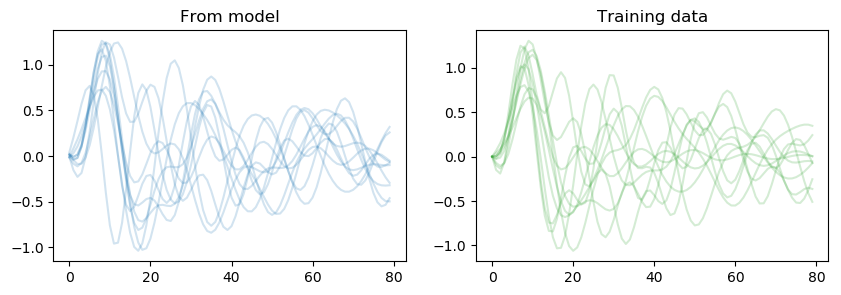

In [117]:
fig, axs = subplots(1,2,figsize=(10,3))
let _u = zeros(Float32, 1, 80, 20); _u[:,1,:] .= 1; 
    _yhat = m_dho2x_u(f32(MTDS.util.sobol_gaussian(20,4)'), _u);
    [axs[1].plot(_yhat[1,:,i], color=ColorMap("tab10")(0), alpha=0.2) for i in 1:10]; 
end;
[axs[2].plot(seq_deterministic2x[i], color=ColorMap("tab10")(2), alpha=0.2) for i in 1:10]; 
axs[1].set_title("From model"); axs[2].set_title("Training data");

The resulting sequences appear to capture the sequence family very well.

## Inference on novel examples
We demonstrate the effectiveness of the inductive bias of the learned sequence family on novel examples via the predictive posterior. Inference uses a somewhat novel approach that was developed precisely for this purpose, see [https://github.com/ornithos/SeqAdaptiveIS](https://github.com/ornithos/SeqAdaptiveIS); also `?seq_amis`. Note:

```julia
using SeqAdaptiveIS
```

in the imports at the top of the page.

In [139]:
# Create novel examples for test data (Sobol sequence is ok, as is also *randomized*)
seq_testnoise2x = []

Random.seed!(90210)
rsob2xtest = MTDS.util.uniform_rand_sobol(N, [p_θ.a, p_θ.b], [p_ρ_log.a, p_ρ_log.b], 
    [p_θ2.a, p_θ2.b], [p_ρ2_log.a, p_ρ2_log.b])
for nn = 1:N
    A1 = trans_matrix_2d(rsob2xtest[nn,1], exp(log(0.5)/rsob2xtest[nn,2]))
    A2 = trans_matrix_2d(rsob2xtest[nn,3], exp(log(0.5)/rsob2xtest[nn,4]))
    _A = cat(A1, A2, dims=[1,2])  # block diag
    Xcur = evaluate_state_deterministic(_A, x0, TS_LEN-1)'*Ctrue'
    push!(seq_testnoise2x,  Xcur[:] .+ randn(TS_LEN)*0.05)
end
seq_testnoise2x = f32(reduce(hcat, seq_testnoise2x));

In [118]:
m_dho2x_u = make_untracked(m_dho2x);

In [134]:
# We need to define the target distributions for inference.

"""
    generate_logjoint(m, y, u, p_z, to_time; batch_size=50, β_def=1f0)

Generates log joint function with signature as below.

    logjoint(S)

Calculate the log joint density of ``p(z, y | u)`` for the model `m` (requires
a defined `logpdf`) and the prior `p_z`, both specified in the closure. This
is calculated only for a *single* (y, u) pair. 

`S` is a `n × k` matrix of `n` `k`-dimensional samples of `z`. The function
returns a vector of length `n` with the log joint per row of `S`.

Generator function additional arguments: `to_time` = length
of sequence, `batch_size` is the number of samples to calculate simultaneously,
`β_def` is the default value of β (weighting of the likelihood vs prior).
"""
function generate_logjoint(m, y, u, p_z, to_time; batch_size=50, β_def=1f0)
    @argcheck length(y) == 80
    @argcheck length(u) == 80
    y, u = unsqueeze(y[1:to_time], 1), u[1:to_time]
    
    function logjoint(S, β=β_def)    # β for annealing
        bsz = batch_size
        n, d = size(S)
        
        # calculate nllh of particles in batches of size `bsz`.
        nllh = map(Iterators.partition(1:n, bsz)) do cbatch
            ŷ = MTDS.model.forward_multiple_z(m, f32(Matrix(S[cbatch, :]')), u)
            MTDS.model._gauss_nllh_individual_bybatch(ŷ, y, m.logstd)
        end
        
        # calculate log joint
        llh = - reduce(vcat, nllh)   # llh
        lp_z = logpdf(p_z, S')       # prior
        return lp_z + β*llh
    end
end

generate_logjoint

### Run inference on first 10 sequences
Calculate the posterior at times $t=5,10,15,\ldots,60$. `seq_amis` runs pretty well out of the box, but occasionally collapses to a low effective sample size (ESS). This can usually be taken care of by increasing the number of samples and epochs, but in my work I also played around with annealing ($\beta$) which works really well, but is slightly more of a pain to implement in a generic way.  (This is a TODO.)

The average posterior (averaged over sequences $i$ and timepoints $t$) takes 0.20-0.25s on my laptop. Which is not bad.

In [154]:
inferenced_dho2x = []
@time for i in 1:10
    printfmtln("========= SEQ INDEX {:d} ========", i)
    p_z = MvNormal(zeros(Float32, 4), Diagonal(ones(Float32, 4)))
    targets = [generate_logjoint(m_dho2x_u, seq_testnoise2x[:,i], _dho_u[:], p_z, t) for t in 5:5:60]
    d, k = 4, 3   # d = dim of inference variable,    k = GMM components
    smps, gmms = seq_amis(targets, d, k; gmm_smps=1000, nepochs=5)
    
    push!(inferenced_dho2x, (smps, gmms))
end

========= SEQ INDEX 1 ========
Posterior 01, ess=638.23, cum. time taken = 0.05s (0.05)
Posterior 02, ess=361.33, cum. time taken = 0.20s (0.15)
Posterior 03, ess=440.41, cum. time taken = 0.33s (0.13)
Posterior 04, ess=447.31, cum. time taken = 0.52s (0.19)
Posterior 05, ess=194.42, cum. time taken = 0.70s (0.18)
Retrying... (ess = 77.1)
Posterior 06, ess=194.31, cum. time taken = 1.07s (0.37)
Posterior 07, ess=453.97, cum. time taken = 1.27s (0.20)
Posterior 08, ess=325.93, cum. time taken = 1.48s (0.21)
Posterior 09, ess=212.01, cum. time taken = 1.69s (0.21)
Posterior 10, ess=407.24, cum. time taken = 1.92s (0.23)
Posterior 11, ess=456.34, cum. time taken = 2.17s (0.24)
Posterior 12, ess=380.09, cum. time taken = 2.43s (0.26)
========= SEQ INDEX 2 ========
Posterior 01, ess=653.44, cum. time taken = 0.04s (0.04)
Posterior 02, ess=304.15, cum. time taken = 0.17s (0.13)
Posterior 03, ess=220.54, cum. time taken = 0.30s (0.13)
Posterior 04, ess=257.63, cum. time taken = 0.45s (0.15)
P

### Plot the predictive posterior
Below shows samples from the predictive posterior after $t=10$ and $t=30$ for a given test sequence. The first 10 observations are insufficient to obtain a precise prediction, but the the first 30 observations (along with the inductive bias from the MTDS) yield an accurate forecast.

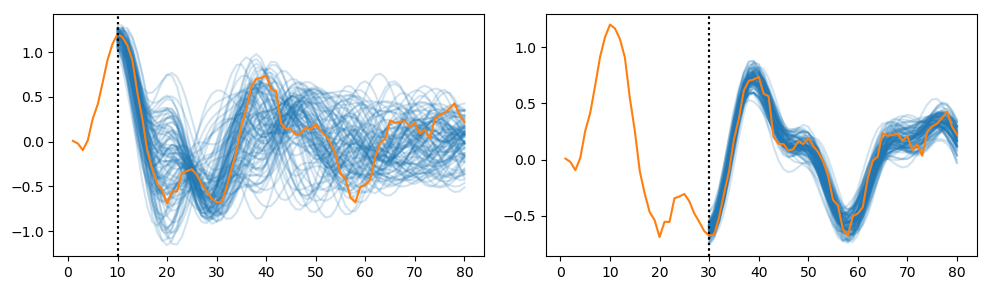

In [167]:
let
    test_ix = 2   # sequence number $i$ of training set
    ts = [10,30]  # seen data up to time `t`
    nsmps = 100   # number of MC samples of posterior predictive
    
    # repeatable
    _rng = MersenneTwister()
    Random.seed!(_rng, 100)
    
    # Plot
    fig, axs = subplots(1,2,figsize=(10,3))
    for (i, t) in enumerate(ts)
        # Get reconstructions from 200 posterior samples
        yhats = let; z=Matrix(f32(resample(_rng, inferenced_dho2x[test_ix][1][t ÷ 5], nsmps))'); 
            MTDS.model.forward_multiple_z(m_dho2x_u, z, _dho_u[:])[1,:,:]; end;
        # Plot
        [axs[i].plot(t:80, yhats[t:80,j], c=ColorMap("tab10")(0), alpha=0.2) for j in 1:nsmps];
        axs[i].plot(1:80, seq_testnoise2x[1:80,test_ix], c=ColorMap("tab10")(1))
        [axs[i].axvline(t, linestyle=":", color="k") for j in 1:2]
    end
    tight_layout()
end

## What happens if we overparameterize the state?

In the previous examples we've used the correct state dimension, which is possible due to our prior knowledge. However, in general we will not know the state dimension, and it will be safer to overestimate it. Can we still learn a good approximation of the sequence family in this case?

In [289]:
m_dho2x8 = create_mtlds(8, 1, 1, 32, 4; encoder=:RNN)

MTLDS_variational(state=8, in=1, out=1, d_mt=4, non-MT hidden state)

In [290]:
# Train
tT = 80              # Total num timesteps (can't use T ∵ julia reserves for type)
nepochs = 250
opt_pars_dho8 = MTDS.model.training_params_mco(samples=800)
_dho_u = reshape(MTDS.util.e1(tT), 1, tT, 1)

history = MTDS.model.train_mco!(m_dho2x8, unsqueeze(seq_noise2x,1), _dho_u, nepochs; opt_pars=opt_pars_dho8, tT=tT)

Epoch 0001 Loss: 148.06, logp: -18.74 (2.3s)
Epoch 0002 Loss: 106.21, logp: 21.13 (2.1s)
Epoch 0003 Loss: 16.27, logp: 85.05 (2.6s)
Epoch 0004 Loss: -85.70, logp: 165.25 (2.5s)
Epoch 0005 Loss: -151.46, logp: 228.69 (2.3s)
Epoch 0006 Loss: -204.10, logp: 274.79 (2.5s)
Epoch 0007 Loss: -254.50, logp: 322.93 (2.1s)
Epoch 0008 Loss: -300.39, logp: 363.93 (2.0s)
Epoch 0009 Loss: -343.96, logp: 403.22 (2.1s)
Epoch 0010 Loss: -390.10, logp: 447.65 (2.1s)
Epoch 0011 Loss: -436.64, logp: 487.49 (2.1s)
Epoch 0012 Loss: -484.84, logp: 524.49 (2.1s)
Epoch 0013 Loss: -538.22, logp: 567.63 (2.2s)
Epoch 0014 Loss: -567.96, logp: 593.92 (2.3s)
Epoch 0015 Loss: -597.54, logp: 619.79 (2.0s)
Epoch 0016 Loss: -638.73, logp: 659.11 (2.2s)
Epoch 0017 Loss: -670.06, logp: 686.30 (2.1s)
Epoch 0018 Loss: -693.19, logp: 706.62 (2.0s)
Epoch 0019 Loss: -723.78, logp: 737.84 (1.9s)
Epoch 0020 Loss: -754.43, logp: 769.61 (1.9s)
Epoch 0021 Loss: -796.59, logp: 810.40 (2.1s)
Epoch 0022 Loss: -837.59, logp: 849.37 (2

Epoch 0174 Loss: -1206.28, logp: 1207.17 (1.9s)
Epoch 0175 Loss: -1227.59, logp: 1228.14 (1.9s)
Epoch 0176 Loss: -1214.13, logp: 1214.60 (2.0s)
Epoch 0177 Loss: -1213.73, logp: 1213.74 (2.0s)
Epoch 0178 Loss: -1199.34, logp: 1198.80 (2.7s)
Epoch 0179 Loss: -1210.91, logp: 1210.51 (2.1s)
Epoch 0180 Loss: -1216.05, logp: 1216.66 (1.9s)
Epoch 0181 Loss: -1229.21, logp: 1229.12 (1.9s)
Epoch 0182 Loss: -1203.49, logp: 1203.63 (2.0s)
Epoch 0183 Loss: -1211.92, logp: 1211.96 (1.9s)
Epoch 0184 Loss: -1198.42, logp: 1198.61 (1.9s)
Epoch 0185 Loss: -1216.89, logp: 1217.11 (1.9s)
Epoch 0186 Loss: -1236.45, logp: 1235.45 (1.9s)
Epoch 0187 Loss: -1212.82, logp: 1212.49 (1.9s)
Epoch 0188 Loss: -1232.49, logp: 1232.26 (1.9s)
Epoch 0189 Loss: -1221.45, logp: 1221.71 (1.9s)
Epoch 0190 Loss: -1228.79, logp: 1230.16 (2.8s)
Epoch 0191 Loss: -1219.78, logp: 1220.48 (2.9s)
Epoch 0192 Loss: -1208.26, logp: 1208.41 (2.0s)
Epoch 0193 Loss: -1225.98, logp: 1226.05 (2.2s)
Epoch 0194 Loss: -1241.42, logp: 1241.47

InterruptException: InterruptException:

### Out of sample marginal log-likelihoods: d=4 state vs d=8.

Higher is better. The marginal log likelihood is averaged over the 40 test examples for each model. The models are optimized for the same number of epochs. The difference is not significant under the variance of the Monte Carlo estimator, and it appears that optimizing the marginal likelihood avoids the overfitting that might be expected with the larger state (as might be expected).

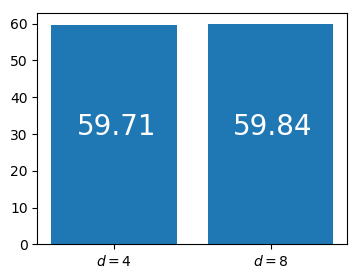

In [341]:
m_dho2x8_u = make_untracked(m_dho2x8);

# Calculate the marginal log likelihood of the original d=4 state model on novel test data
_, _, logp_2x4 = MTDS.model.aggregate_importance_smp(m_dho2x_u, unsqueeze(seq_testnoise2x,1), _dho_u; M=1200);

# Calculate the marginal log likelihood of the current d=8 state model on novel test data
_, _, logp_2x8 = MTDS.model.aggregate_importance_smp(m_dho2x8_u, unsqueeze(seq_testnoise2x,1), _dho_u; M=1200);

# Normalize by test batch size
Nb = size(seq_testnoise2x,2)
logp_2x4, logp_2x8 = logp_2x4 / Nb, logp_2x8 / Nb

bar([1,2], [logp_2x4, logp_2x8], tick_label=[L"d=4", L"d=8"])
text(1-0.24, logp_2x4/2, format("{:.2f}", logp_2x4), fontsize=20, color="white")
text(2-0.24, logp_2x8/2, format("{:.2f}", logp_2x8), fontsize=20, color="white")
gcf().set_size_inches(4,3)

### Random samples from model
Perform model checking by drawing samples from the model. It's hard to gain much from visualizing the 4-D latent space without extra work.

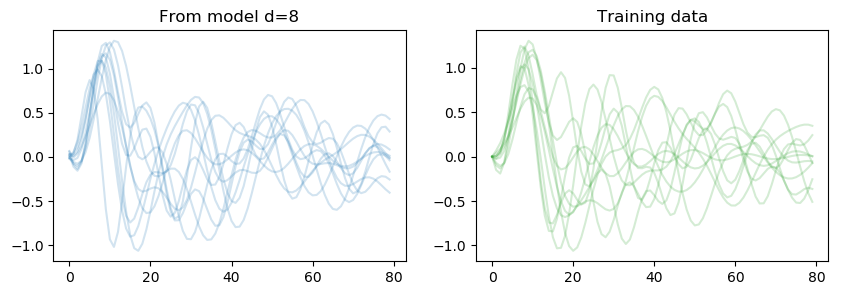

In [342]:
fig, axs = subplots(1,2,figsize=(10,3))
let _u = zeros(Float32, 1, 80, 20); _u[:,1,:] .= 1; 
    _yhat = Tracker.data(m_dho2x8(f32(MTDS.util.sobol_gaussian(20,4)'), _u));
    [axs[1].plot(_yhat[1,:,i], color=ColorMap("tab10")(0), alpha=0.2) for i in 1:10]; 
end;
[axs[2].plot(seq_deterministic2x[i], color=ColorMap("tab10")(2), alpha=0.2) for i in 1:10]; 
axs[1].set_title("From model d=8"); axs[2].set_title("Training data");

------------------
# Time series with inputs

The above examples demonstrate that we can learn a good approximation of the sequence family of mechanical action -- which is deterministic given the initial conditions. We now turn to a simple case where the sequence depends on external inputs.

In [172]:
# utilities

function make_se_kernel(ts1::AbstractVector, ts2::AbstractVector, σ::Number=1)
    K = exp.(-[(t1 - t2).^2 for t1 in ts1, t2 in ts2] ./ σ.^2)
    return (K + K')/2 + 1e-9*I
end
make_se_kernel_sym(ts1::AbstractVector, σ::Number=1) = make_se_kernel(ts1, ts1, σ)

function _lds_model_forward_parvector(U::AbstractMatrix{T}, A::AbstractMatrix{T}, B::AbstractMatrix{T},
        C::AbstractMatrix{T}, d::AbstractMatrix{T}, h0::AbstractVecOrMat{T}=zeros(T, size(A,1))) where T <: AbstractFloat
    n_u, tT = size(U)
    lds = Flux.Recur(MTDS.model.LDSCell_simple_u(A, B, h0))
    lds_state = [lds(U[:,t]) for t in 1:tT]
    X = cat(lds_state..., dims=2)
    return C * X .+ d
end

_lds_model_forward_parvector (generic function with 2 methods)

### Generate time series data which depends on inputs

Inputs are generated from a GP with SE kernel with unit scale length. The sequences are generated from an LDS with parameters:

$$
A = \begin{bmatrix} \cos(\theta_1) & \sin(\theta_1) & 0 & 0 \\ -\sin(\theta) & cos(\theta) & 0 & 0 \\ 0 & 0 &  \cos(\theta_2) & \sin(\theta_2) \\ 0 & 0 & -\sin(\theta_2) & cos(\theta_2) \end{bmatrix} \times \begin{bmatrix} 0.99 & 0 & 0 & 0 \\ 0 & 0.8 & 0 & 0 \\ 0 & 0 & 0.3 & 0 \\ 0 & 0 & 0 & 0.9 \end{bmatrix}\\
B= (-1)^{\mathbb{1}\{z_1>0\}} e_{z_2}, \qquad C = \frac{1}{4}\begin{bmatrix} 1 & 1 & 1 & 1 \end{bmatrix}
$$

where $e_z$ is the $z$th unit vector (e.g. for $z=2$, $e_z = \begin{bmatrix} 0 & 1 & 0 & 0 \end{bmatrix}^T$). $B$ is also either positive or negative depending on $z$. Capturing this diversion of inputs to different state dimensions makes for a non-obvious modelling problem.

In [210]:
Random.seed!(101010)

N = 120
Us = cholesky(make_se_kernel_sym(1:80, 6)).L * randn(80, N);

Ys = map(1:N) do i
    rotm = let; θ₁=0.03; θ₂=0.02; cat([cos(θ₁) sin(θ₁); -sin(θ₁) cos(θ₁)], 
            [cos(θ₂) sin(θ₂); -sin(θ₂) cos(θ₂)], dims=[1,2]); end
    _genA = f32(rotm * diagm(0=>[0.99,0.8,0.3,0.9]))
    _genB = rand([1,-1]) * unsqueeze(MTDS.util.e_k(4,rand(1:4)), 2)
    _genC = f32([1 1 1 1]/4)
    _lds_model_forward_parvector(f32(reshape(Us[:,i], 1, 80)), _genA, _genB, _genC, 
        zeros(Float32, 1, 1)) .+ randn()
end
Ys = f32(Matrix(reduce(vcat, Ys)'));
Us = f32(Us);

# Training
Create MT-LDS with 4-dimensional latent state and 3-dimensional latent $z$. For the true model, $z$ only has two degrees of freedom, although their effects are highly nonlinear on the LDS parameters.

In [211]:
m3 = MTDS.create_mtlds(4, 1, 1, 32, 3; encoder=:RNN)

MTLDS_variational(state=4, in=1, out=1, d_mt=3, non-MT hidden state)

In [212]:
tT = 80
nepochs = 500
opt_pars = MTDS.model.training_params_elbo(kl_mult=1, kl_anneal=5f-3)


history = MTDS.model.train_elbo!(m3, unsqueeze(Ys,1), unsqueeze(Us,1), nepochs; opt_pars=opt_pars, tT=tT)

Epoch 0001 Loss: 2425.43, kl: 0.00, p_logstd: 44.60 (0.8s)
Epoch 0002 Loss: 2230.17, kl: 0.00, p_logstd: 87.32 (0.9s)
Epoch 0003 Loss: 1647.92, kl: 0.00, p_logstd: 123.05 (0.7s)
Epoch 0004 Loss: 1173.14, kl: 0.00, p_logstd: 146.86 (0.8s)
Epoch 0005 Loss: 1207.99, kl: 0.00, p_logstd: 167.15 (0.8s)
Epoch 0006 Loss: 1646.59, kl: 78.62, p_logstd: 195.40 (0.7s)
Epoch 0007 Loss: 1496.65, kl: 83.01, p_logstd: 225.21 (0.8s)
Epoch 0008 Loss: 1386.52, kl: 94.38, p_logstd: 251.15 (0.8s)
Epoch 0009 Loss: 1198.47, kl: 106.52, p_logstd: 270.33 (0.9s)
Epoch 0010 Loss: 1248.56, kl: 115.79, p_logstd: 288.26 (0.8s)
Epoch 0011 Loss: 1145.11, kl: 111.17, p_logstd: 303.86 (0.7s)
Epoch 0012 Loss: 1197.49, kl: 108.88, p_logstd: 319.13 (0.8s)
Epoch 0013 Loss: 1190.50, kl: 116.39, p_logstd: 333.94 (0.7s)
Epoch 0014 Loss: 1121.32, kl: 113.33, p_logstd: 346.51 (0.7s)
Epoch 0015 Loss: 1177.99, kl: 110.43, p_logstd: 359.42 (0.8s)
Epoch 0016 Loss: 1183.68, kl: 112.31, p_logstd: 374.35 (0.8s)
Epoch 0017 Loss: 1081.6

Epoch 0136 Loss: 583.40, kl: 141.19, p_logstd: 120.02 (1.5s)
Epoch 0137 Loss: 590.32, kl: 144.10, p_logstd: 115.10 (1.2s)
Epoch 0138 Loss: 607.42, kl: 144.01, p_logstd: 111.55 (1.5s)
Epoch 0139 Loss: 594.33, kl: 142.93, p_logstd: 108.04 (0.8s)
Epoch 0140 Loss: 551.70, kl: 141.21, p_logstd: 102.63 (1.1s)
Epoch 0141 Loss: 531.12, kl: 140.86, p_logstd: 96.41 (0.8s)
Epoch 0142 Loss: 591.65, kl: 144.71, p_logstd: 92.11 (0.9s)
Epoch 0143 Loss: 543.70, kl: 146.61, p_logstd: 87.33 (0.9s)
Epoch 0144 Loss: 530.83, kl: 145.86, p_logstd: 81.08 (0.8s)
Epoch 0145 Loss: 539.46, kl: 144.41, p_logstd: 75.47 (0.8s)
Epoch 0146 Loss: 544.86, kl: 145.99, p_logstd: 70.35 (0.8s)
Epoch 0147 Loss: 533.37, kl: 146.24, p_logstd: 65.88 (0.8s)
Epoch 0148 Loss: 513.15, kl: 146.73, p_logstd: 59.81 (0.8s)
Epoch 0149 Loss: 502.57, kl: 142.59, p_logstd: 53.58 (0.8s)
Epoch 0150 Loss: 501.85, kl: 146.66, p_logstd: 47.76 (0.8s)
Epoch 0151 Loss: 488.47, kl: 144.58, p_logstd: 42.10 (0.9s)
Epoch 0152 Loss: 491.46, kl: 146.69

Epoch 0270 Loss: 245.77, kl: 175.95, p_logstd: -283.05 (0.8s)
Epoch 0271 Loss: 231.95, kl: 177.80, p_logstd: -284.81 (0.8s)
Epoch 0272 Loss: 283.63, kl: 178.59, p_logstd: -285.87 (0.9s)
Epoch 0273 Loss: 268.81, kl: 180.25, p_logstd: -286.49 (0.8s)
Epoch 0274 Loss: 272.70, kl: 178.73, p_logstd: -287.13 (0.8s)
Epoch 0275 Loss: 252.05, kl: 179.19, p_logstd: -288.14 (0.9s)
Epoch 0276 Loss: 237.56, kl: 178.80, p_logstd: -289.44 (1.1s)
Epoch 0277 Loss: 251.20, kl: 179.82, p_logstd: -290.89 (1.1s)
Epoch 0278 Loss: 269.71, kl: 180.47, p_logstd: -291.76 (0.9s)
Epoch 0279 Loss: 228.92, kl: 181.39, p_logstd: -293.26 (0.9s)
Epoch 0280 Loss: 242.01, kl: 179.91, p_logstd: -294.79 (0.9s)
Epoch 0281 Loss: 260.27, kl: 180.61, p_logstd: -295.58 (0.9s)
Epoch 0282 Loss: 269.06, kl: 179.71, p_logstd: -296.37 (0.9s)
Epoch 0283 Loss: 231.82, kl: 179.92, p_logstd: -297.29 (1.1s)
Epoch 0284 Loss: 268.71, kl: 180.94, p_logstd: -298.09 (0.8s)
Epoch 0285 Loss: 255.55, kl: 180.75, p_logstd: -298.85 (0.9s)
Epoch 02

Epoch 0403 Loss: 157.10, kl: 192.08, p_logstd: -385.41 (1.0s)
Epoch 0404 Loss: 166.81, kl: 190.55, p_logstd: -385.80 (0.8s)
Epoch 0405 Loss: 169.48, kl: 190.43, p_logstd: -386.21 (0.9s)
Epoch 0406 Loss: 175.43, kl: 192.57, p_logstd: -386.48 (0.8s)
Epoch 0407 Loss: 169.28, kl: 191.34, p_logstd: -386.89 (0.8s)
Epoch 0408 Loss: 150.59, kl: 191.44, p_logstd: -387.32 (0.8s)
Epoch 0409 Loss: 142.50, kl: 192.17, p_logstd: -387.84 (0.8s)
Epoch 0410 Loss: 196.05, kl: 191.13, p_logstd: -388.11 (0.8s)
Epoch 0411 Loss: 177.41, kl: 189.50, p_logstd: -388.28 (0.9s)
Epoch 0412 Loss: 143.02, kl: 190.96, p_logstd: -388.72 (0.8s)
Epoch 0413 Loss: 169.64, kl: 191.52, p_logstd: -389.06 (0.9s)
Epoch 0414 Loss: 181.03, kl: 191.60, p_logstd: -389.36 (0.8s)
Epoch 0415 Loss: 177.93, kl: 191.10, p_logstd: -389.52 (0.9s)
Epoch 0416 Loss: 165.75, kl: 191.98, p_logstd: -389.87 (1.0s)
Epoch 0417 Loss: 163.03, kl: 192.24, p_logstd: -390.12 (0.8s)
Epoch 0418 Loss: 153.05, kl: 191.05, p_logstd: -390.61 (0.8s)
Epoch 04

500-element Array{Float64,1}:
 2425.429443359375  
 2230.171875        
 1647.91748046875   
 1173.13525390625   
 1207.9892578125    
 1646.59033203125   
 1496.6534423828125 
 1386.5240478515625 
 1198.4710693359375 
 1248.5615234375    
 1145.1083984375    
 1197.4881591796875 
 1190.498779296875  
    ⋮               
  151.14144897460938
  138.39022827148438
  150.6260986328125 
  104.5339126586914 
  147.2286834716797 
  116.98970031738281
  144.47006225585938
  160.52496337890625
  140.8584747314453 
  158.2938995361328 
  166.91575622558594
  177.93280029296875

In [224]:
history2 = MTDS.model.train_elbo!(m3, unsqueeze(Ys,1), unsqueeze(Us,1), 250; opt_pars=opt_pars, tT=tT)

Epoch 0001 Loss: -18.49, kl: 208.37, p_logstd: -592.10 (0.8s)
Epoch 0002 Loss: -30.40, kl: 208.16, p_logstd: -592.41 (0.8s)
Epoch 0003 Loss: -48.30, kl: 208.44, p_logstd: -592.69 (0.9s)
Epoch 0004 Loss: -48.26, kl: 206.31, p_logstd: -593.11 (0.9s)
Epoch 0005 Loss: -16.17, kl: 210.64, p_logstd: -593.38 (0.9s)
Epoch 0006 Loss: -40.89, kl: 207.77, p_logstd: -593.71 (0.8s)
Epoch 0007 Loss: -15.34, kl: 208.57, p_logstd: -593.91 (1.2s)
Epoch 0008 Loss: -53.80, kl: 205.59, p_logstd: -594.19 (1.0s)
Epoch 0009 Loss: -33.57, kl: 207.84, p_logstd: -594.52 (1.1s)
Epoch 0010 Loss: -37.20, kl: 207.27, p_logstd: -594.80 (1.1s)
Epoch 0011 Loss: -14.09, kl: 207.65, p_logstd: -595.01 (1.1s)
Epoch 0012 Loss: -41.07, kl: 206.89, p_logstd: -595.28 (0.9s)
Epoch 0013 Loss: -50.35, kl: 207.24, p_logstd: -595.60 (1.1s)
Epoch 0014 Loss: -52.73, kl: 207.61, p_logstd: -595.94 (1.0s)
Epoch 0015 Loss: -40.09, kl: 208.09, p_logstd: -596.26 (0.9s)
Epoch 0016 Loss: -30.29, kl: 207.61, p_logstd: -596.50 (0.9s)
Epoch 00

Epoch 0134 Loss: -66.93, kl: 207.62, p_logstd: -612.90 (0.8s)
Epoch 0135 Loss: -47.02, kl: 210.34, p_logstd: -612.98 (0.9s)
Epoch 0136 Loss: -32.41, kl: 208.08, p_logstd: -613.03 (0.9s)
Epoch 0137 Loss: -52.41, kl: 211.83, p_logstd: -613.10 (0.9s)
Epoch 0138 Loss: -17.57, kl: 210.26, p_logstd: -613.15 (0.8s)
Epoch 0139 Loss: -63.65, kl: 209.55, p_logstd: -613.21 (0.8s)
Epoch 0140 Loss: -68.18, kl: 211.17, p_logstd: -613.31 (0.8s)
Epoch 0141 Loss: -39.50, kl: 208.83, p_logstd: -613.39 (0.8s)
Epoch 0142 Loss: -42.97, kl: 210.38, p_logstd: -613.45 (0.9s)
Epoch 0143 Loss: -42.75, kl: 209.91, p_logstd: -613.51 (0.9s)
Epoch 0144 Loss: -34.97, kl: 209.23, p_logstd: -613.56 (0.9s)
Epoch 0145 Loss: -72.21, kl: 208.82, p_logstd: -613.64 (0.9s)
Epoch 0146 Loss: -55.85, kl: 210.54, p_logstd: -613.73 (0.8s)
Epoch 0147 Loss: -63.00, kl: 210.86, p_logstd: -613.81 (0.8s)
Epoch 0148 Loss: -56.07, kl: 210.84, p_logstd: -613.90 (0.8s)
Epoch 0149 Loss: -52.74, kl: 209.98, p_logstd: -613.97 (0.8s)
Epoch 01

250-element Array{Float64,1}:
 -18.48947525024414 
 -30.40447235107422 
 -48.2963981628418  
 -48.25640869140625 
 -16.16759490966797 
 -40.886898040771484
 -15.337034225463867
 -53.8030891418457  
 -33.57255554199219 
 -37.2045783996582  
 -14.087453842163086
 -41.071414947509766
 -50.34832000732422 
   ⋮                
 -48.31300354003906 
 -67.5248794555664  
 -43.72337341308594 
 -47.12285232543945 
 -62.41234588623047 
 -33.75991439819336 
 -51.58673095703125 
 -68.89214324951172 
 -65.10015106201172 
 -42.264129638671875
 -85.14783477783203 
 -41.16326141357422 

In [227]:
m3_u = make_untracked(m3);

In [228]:
# Calculate aggregate posterior
aggpost_μ = MTDS.encode(m3_u, unsqueeze(Ys, 1), unsqueeze(Us, 1) )[1][2]
aggpost_σ = MTDS.encode(m3_u, unsqueeze(Ys, 1), unsqueeze(Us, 1) )[1][3]
p_z = MvNormal(mean(aggpost_μ; dims=2)[:], cov(aggpost_μ; dims=2) + Diagonal(mean(aggpost_σ; dims=2)[:]))

MvNormal{Float32,PDMats.PDMat{Float32,Array{Float32,2}},Array{Float32,1}}(
dim: 3
μ: Float32[0.109889, -0.168156, 0.00727295]
Σ: Float32[1.09648 -0.00467098 0.171635; -0.00467098 1.94133 0.219755; 0.171635 0.219755 1.16499]
)


## Inference on novel examples

Calculate the posterior at times $t=5,10,15,\ldots,60$.

In [230]:
# Generate novel test cases
Random.seed!(9999)

N = 20
Us_test = cholesky(make_se_kernel_sym(1:80, 6)).L * randn(80, N);

Ys_test = map(1:N) do i
    rotm = let; θ₁=0.03; θ₂=0.02; cat([cos(θ₁) sin(θ₁); -sin(θ₁) cos(θ₁)], 
            [cos(θ₂) sin(θ₂); -sin(θ₂) cos(θ₂)], dims=[1,2]); end
    _genA = f32(rotm * diagm(0=>[0.99,0.8,0.3,0.9]))
    _genB = rand([1,-1]) * unsqueeze(MTDS.util.e_k(4,rand(1:4)), 2)
    _genC = f32([1 1 1 1]/4)
    _lds_model_forward_parvector(f32(reshape(Us_test[:,i], 1, 80)), _genA, _genB, _genC, 
        zeros(Float32, 1, 1)) .+ randn()
end
Ys_test = f32(Matrix(reduce(vcat, Ys_test)'));
Us_test = f32(Us_test);

In [238]:
inferenced3 = []
for i in 1:10
    printfmtln("========= SEQ INDEX {:d} ========", i)
    targets = [generate_logjoint(m3_u, Ys_test[:,i], Us_test[:,i], p_z, t) for t in 5:5:60]
    d, k = 3, 3   # d = dim of inference variable,    k = GMM components
    smps, gmms = seq_amis(targets, d, k; gmm_smps=2000, nepochs=5)
    
    push!(inferenced3, (smps, gmms))
end

========= SEQ INDEX 1 ========
Posterior 01, ess=933.81, cum. time taken = 0.21s (0.21)
Posterior 02, ess=880.13, cum. time taken = 0.47s (0.26)
Posterior 03, ess=1229.64, cum. time taken = 0.70s (0.22)
Posterior 04, ess=1078.35, cum. time taken = 1.01s (0.31)
Retrying... (ess = 86.8)
Posterior 05, ess=1072.11, cum. time taken = 1.80s (0.79)
Posterior 06, ess=1247.40, cum. time taken = 1.95s (0.15)
Posterior 07, ess=1260.08, cum. time taken = 2.13s (0.18)
Posterior 08, ess=1207.11, cum. time taken = 2.32s (0.19)
Posterior 09, ess=1155.40, cum. time taken = 2.76s (0.44)
Posterior 10, ess=1204.02, cum. time taken = 2.95s (0.19)
Posterior 11, ess=807.18, cum. time taken = 3.45s (0.50)
Posterior 12, ess=795.55, cum. time taken = 4.05s (0.60)
========= SEQ INDEX 2 ========
Posterior 01, ess=704.68, cum. time taken = 0.29s (0.29)
Posterior 02, ess=838.66, cum. time taken = 0.53s (0.24)
Posterior 03, ess=847.41, cum. time taken = 0.80s (0.27)
Posterior 04, ess=683.76, cum. time taken = 1.13s 

### Sample the reproductive posterior
Here we use the RNN encoder and variational posterior learned by the model on the training data.

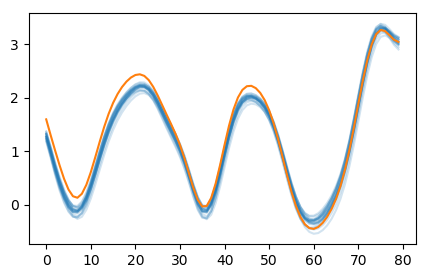

In [282]:
seq_i = 1
[plot(MTDS.reconstruct(m3_u, unsqueeze(Ys[:, seq_i:seq_i],1), unsqueeze(Us[:, seq_i:seq_i],1))[:], 
        color=ColorMap("tab10")(0), alpha=0.2) for i in 1:20]
plot(Ys[:,seq_i], color=ColorMap("tab10")(1)); gcf().set_size_inches(5,3)

### Plot the predictive posterior
Below shows samples from the predictive posterior after $t=10$ and $t=30$ for a given test sequence. The first 10 observations are insufficient to obtain a precise prediction, but the the first 30 observations (along with the inductive bias from the MTDS) are sufficient for a reasonable forecast.

Note the change in $y$-axis scale between the plots due to the reduction in variance of the predictive posterior.

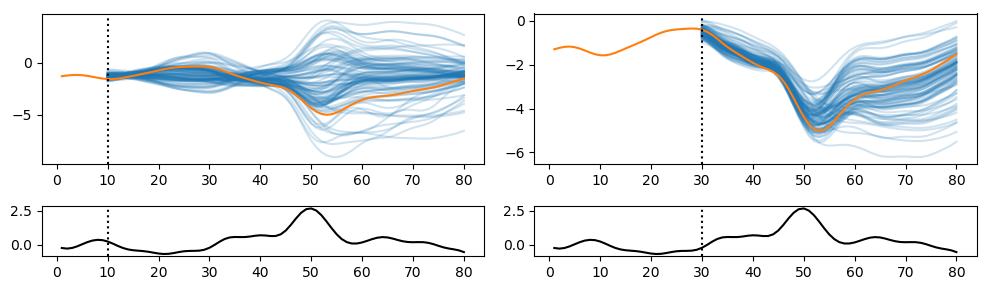

In [287]:
let
    test_ix = 5   # sequence number $i$ of training set
    ts = [10,30]  # seen data up to time `t`
    nsmps = 100   # number of MC samples of posterior predictive
    
    # repeatable
    _rng = MersenneTwister()
    Random.seed!(_rng, 100)
    
    # Plot
    fig, axs = subplots(2,2,figsize=(10,3), gridspec_kw=Dict("height_ratios"=>[3, 1]))
    for (i, t) in enumerate(ts)
        # Get reconstructions from 200 posterior samples
        yhats = let; z=Matrix(f32(resample(_rng, inferenced3[test_ix][1][t ÷ 5], nsmps))'); 
            MTDS.model.forward_multiple_z(m3_u, z, Us_test[:, test_ix])[1,:,:]; end;
        # Plot
        [axs[1,i].plot(t:80, yhats[t:80, j], c=ColorMap("tab10")(0), alpha=0.2) for j in 1:nsmps];
        axs[1,i].plot(1:80, Ys_test[1:80, test_ix], c=ColorMap("tab10")(1))
        axs[2,i].plot(1:80, Us_test[:, test_ix], c="k")
        [axs[j,i].axvline(t, linestyle=":", color="k") for j in 1:2]
    end
    tight_layout()
end

# Bibliography

* R. Douc, E. Moulines, and D. Stoffer. Nonlinear Time Series: Theory, Methods and Applications with R Examples. Chapman and Hall/CRC, 2014.
* A. Makhzani, J. Shlens, N. Jaitly, and I. J. Goodfellow. Adversarial autoencoders. CoRR, abs/1511.05644, 2015.
* A. Mnih and D. Rezende. Variational Inference for Monte Carlo Objectives. ICML, 2016.
* M. D. Hoffman and M. J. Johnson. ELBO Surgery: Yet Another Way to Carve up the Variational Evidence Lower Bound. In Workshop in Advances in Approximate Bayesian Inference, NIPS, 2016.